# Shmoo Plot Demo

In [ ]:
## set tty

In [80]:
# Equipment setup

import pyvisa
import time
import subprocess
import serial

# Establish connection to the power supply
rm = pyvisa.ResourceManager("@py")

#psu = rm.open_resource('TCPIP::169.254.58.10::gpib0,7::INSTR')                  ## for the Agilent power supply

psu = rm.open_resource('TCPIP::169.254.201.77::lan0::INSTR')                    ## for the Keysight power supply

clk = rm.open_resource('TCPIP::169.254.201.101::lan0::INSTR')

# Need to verify that this is the power supply. psu_verification should be 
# something like "Keysight Technologies,E3646A,0,X.X-Y.Y-Z.Z"
psu_verification = psu.query("*IDN?")
clk_verification = clk.query("*IDN?")

print("Power supply:", psu_verification)
print("Clock generator:", clk_verification)

# psu.write("*RST")  # Reset the power supply

start_voltage = 0.5

end_voltage = 1.05

step_size = 0.05  

start_clock = 50

end_clock = 100

step_size_clock = 25

# Loop through the voltage range and set the voltage
current_voltage = start_voltage 

current_clock = start_clock

psu.write("OUTP ON, (@2)")

# Only channel 2 works
psu.write("INST:SEL CH2")

# Set current to 100mA
psu.write("CURR 0.1")

# Start the clock at 20MHz
clk.write(":OUTP1:POS ON") # Initialize clk gen channel 1 output
clk.write(":FUNC:PATT")


expected_output = "32767 32767 32767 32767 32767 32767 32767 32767 32767 32767"

Power supply: Keysight Technologies,E36312A,MY57010726,1.0.4-1.0.0-1.04

Clock generator: Agilent Technologies, 81134A, DE42800131, Ver 2.9.3



#### Remember to reset the board!

In [82]:
while current_clock <= end_clock:
     # remake to adjust with the frequency
     subprocess.run(["make", "clean"], cwd="../../")

     with open("../../platform/bearly24/freq.h", "w") as f:
          f.write('''#ifndef __FREQ_H
                    #define __FREQ_H
                    ''')
          f.write(f'''#define MTIME_FREQ     {current_clock}000000
                    #define SYS_CLK_FREQ   {current_clock}000000
                    ''')
          f.write("#endif")

     subprocess.run(["make", "shmoo_bearly"], cwd="../../")

     clk.write(f":FREQ {current_clock}MHz")
     print(f"**Clock set to: {current_clock}MHz**") 


     while current_voltage <= end_voltage: # Set the voltage   
          psu.write(f"VOLT {current_voltage}")
          psu.write("OUTP ON, (@2)")

          voltage = psu.query("VOLT?") 
          print(f"**Voltage set to: {voltage}V**") 

          # test subprocess with simple hello
          with subprocess.Popen(["uart_tsi", "+tty=/dev/ttyUSB2", "+baudrate=921600", "../../build/shmoo_bench.elf"]) as proc:
               measured_voltages = []
               measured_currents = []
               start_time = time.time()
               timeout = False
               with serial.Serial('/dev/ttyUSB0', 115200, timeout=7) as ser:
                    while (ser.inWaiting() == 0):
                         ## measure the voltage + current
                         if time.time() - start_time >= 7:
                              timeout = True
                              break
                         measured_voltages.append(psu.query("MEAS:VOLT?"))
                         measured_currents.append(psu.query("MEAS:CURR?"))
                    if timeout:
                         length = min(len(measured_currents), len(measured_voltages))
                         power_consumption = sum([float(measured_voltages[i]) * float(measured_currents[i]) for i in range(length)]) / length
                         with open('../../output.txt', 'a') as file:
                              file.write(f"Freq: {current_clock}, Voltage: {current_voltage}, Output: Invalid, Power: {power_consumption}\n")
                              proc.terminate()
                              proc.wait()     
                    else:
                         line = ser.readline()
                         new_line = line.decode("utf-8")

                         res = "Valid"
                         if not new_line.strip() == expected_output.strip():
                              res = "Invalid"
                         
                         ## calculate power consumption
                         length = min(len(measured_currents), len(measured_voltages))
                         power_consumption = sum([float(measured_voltages[i]) * float(measured_currents[i]) for i in range(length)]) / length
                         with open('../../output.txt', 'a') as file:
                              file.write(f"Freq: {current_clock}, Voltage: {current_voltage}, Output: {res}, Power {power_consumption}\n")
                              proc.terminate()
                              proc.wait()
          


          print("Done: now reset during the sleep before next iteration")
          time.sleep(7)

          current_voltage += step_size
     current_voltage = start_voltage
     current_clock += step_size_clock

print("Finished")

psu.close()

current_clock = start_clock
current_voltage = start_voltage

rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=bearly24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 13.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-g++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Including HTIF to target
-- Including CLINT to target
-- ================ Glossy config ================
--  Building for CHIP: "bearly24"
--

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  8%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 11%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 11%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 13%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 16%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 27%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 27%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 33%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 36%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/chip.c.obj
[ 38%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/src/hal_dma.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c: In function 'dma_init_memcpy':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:20:18: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   20 |   DMAX->SRC_ADDR = (uint64_t) src;
      |                  ^
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:21:19: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   21 |   DMAX->DEST_ADDR = (uint64_t) dst;
      |                   ^
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c: In function 'dma_init_MAC':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:33:18: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   33 |   DMAX->SRC_ADDR = (uint64_t) src;
      |     

[ 41%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 44%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 44%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 47%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 50%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 52%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 55%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 58%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 63%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 72%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 75%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 77%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 80%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 83%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 86%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 88%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 91%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/nearmem_matmul/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:56:47: warning: expression does not compute the number of elements in this array; element type is 'uint64_t' {aka 'volatile long unsigned int'}, not 'uint8_t' {aka 'unsigned char'} [-Wsizeof-array-div]
   56 |     int8_t operandReg[sizeof(DMA1->operandReg)/sizeof(uint8_t)];
      |                                               ^
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:56:47: note: add parentheses around the second 'sizeof' to silence this warning
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:65:43: warning: expression does not compute the number of elements in this array; element type is 'uint64_t' {aka 'volatile long unsigned int'}, not 'int16_t' {aka 'short int'} [-Wsizeof-array-div]
   65 |     int16_t expected[sizeof(DMA1->destReg)/sizeof(int16_t)];
 

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 50MHz**
**Voltage set to: +5.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=bearly24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 13.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
--

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  8%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 11%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 11%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 13%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 16%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 27%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 27%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 33%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 36%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/chip.c.obj
[ 38%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/src/hal_dma.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c: In function 'dma_init_memcpy':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:20:18: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   20 |   DMAX->SRC_ADDR = (uint64_t) src;
      |                  ^
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:21:19: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   21 |   DMAX->DEST_ADDR = (uint64_t) dst;
      |                   ^
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c: In function 'dma_init_MAC':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:33:18: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   33 |   DMAX->SRC_ADDR = (uint64_t) src;
      |     

[ 41%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 44%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 44%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 47%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 50%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 52%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 55%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 58%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 63%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 72%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 75%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 77%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 80%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 83%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 86%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 88%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 91%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/nearmem_matmul/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:56:47: warning: expression does not compute the number of elements in this array; element type is 'uint64_t' {aka 'volatile long unsigned int'}, not 'uint8_t' {aka 'unsigned char'} [-Wsizeof-array-div]
   56 |     int8_t operandReg[sizeof(DMA1->operandReg)/sizeof(uint8_t)];
      |                                               ^
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:56:47: note: add parentheses around the second 'sizeof' to silence this warning
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:65:43: warning: expression does not compute the number of elements in this array; element type is 'uint64_t' {aka 'volatile long unsigned int'}, not 'int16_t' {aka 'short int'} [-Wsizeof-array-div]
   65 |     int16_t expected[sizeof(DMA1->destReg)/sizeof(int16_t)];
 

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 75MHz**
**Voltage set to: +5.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=bearly24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 13.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
--

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  8%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 11%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 11%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 13%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 16%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 27%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 27%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 33%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 36%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/chip.c.obj
[ 38%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/src/hal_dma.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c: In function 'dma_init_memcpy':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:20:18: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   20 |   DMAX->SRC_ADDR = (uint64_t) src;
      |                  ^
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:21:19: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   21 |   DMAX->DEST_ADDR = (uint64_t) dst;
      |                   ^
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c: In function 'dma_init_MAC':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/bearly24/src/hal_dma.c:33:18: warning: assignment to 'volatile void *' from 'long unsigned int' makes pointer from integer without a cast [-Wint-conversion]
   33 |   DMAX->SRC_ADDR = (uint64_t) src;
      |     

[ 41%] Building C object platform/bearly24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 44%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 44%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 47%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 50%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 52%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 55%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 58%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 63%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 72%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 75%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 77%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 80%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 83%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 86%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 88%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 91%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/nearmem_matmul/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:56:47: warning: expression does not compute the number of elements in this array; element type is 'uint64_t' {aka 'volatile long unsigned int'}, not 'uint8_t' {aka 'unsigned char'} [-Wsizeof-array-div]
   56 |     int8_t operandReg[sizeof(DMA1->operandReg)/sizeof(uint8_t)];
      |                                               ^
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:56:47: note: add parentheses around the second 'sizeof' to silence this warning
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/nearmem_matmul/src/main.c:65:43: warning: expression does not compute the number of elements in this array; element type is 'uint64_t' {aka 'volatile long unsigned int'}, not 'int16_t' {aka 'short int'} [-Wsizeof-array-div]
   65 |     int16_t expected[sizeof(DMA1->destReg)/sizeof(int16_t)];
 

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 100MHz**
**Voltage set to: +5.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB2
Checking connection status with /dev/ttyUSB2
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
Finished


#### Generate Shmoo Plot

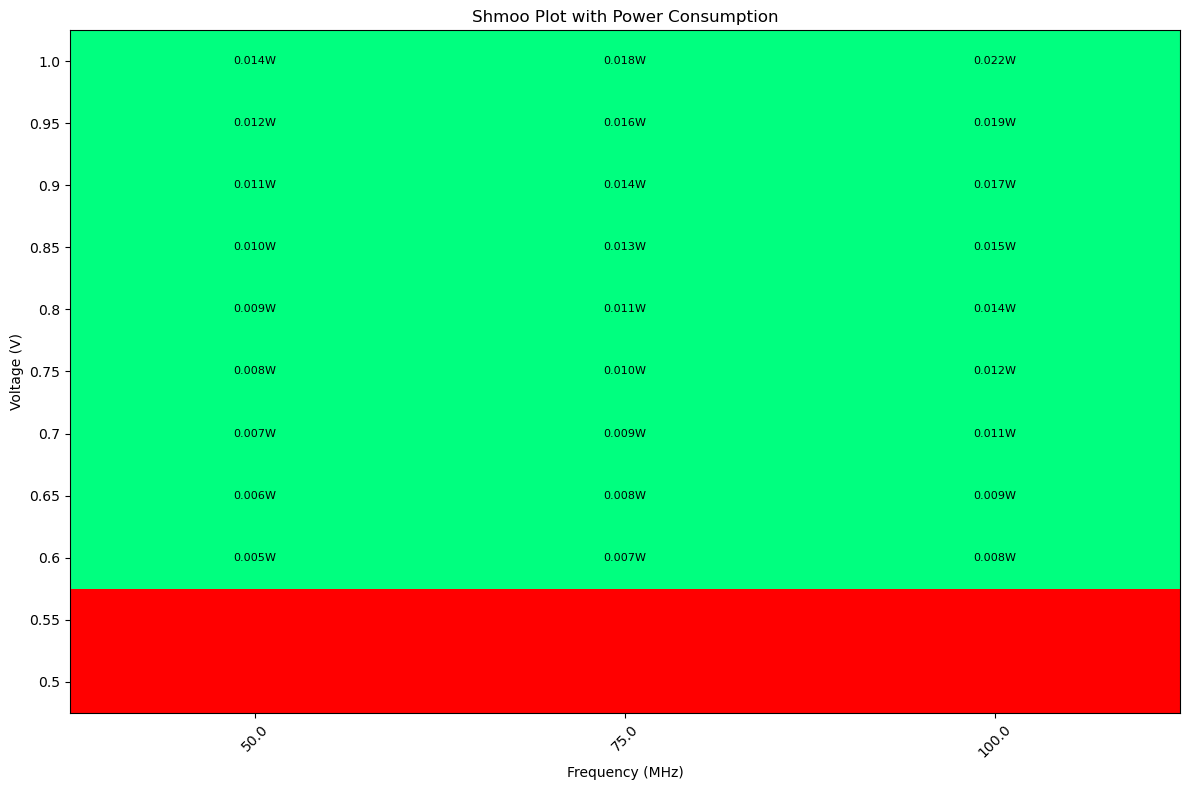

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def read_data(file_name):
    freq_values = []
    voltage_values = []
    valid_values = []
    power_values = []

    with open(file_name, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            freq = float(parts[0].split(': ')[1])
            voltage = round(float(parts[1].split(': ')[1]), 2)
            valid = parts[2].split(': ')[1]
            power = float(parts[3].split(': ')[1])

            freq_values.append(freq)
            voltage_values.append(voltage)
            valid_values.append(valid)
            power_values.append(power)
    
    return freq_values, voltage_values, valid_values, power_values

file_name = '../../output.txt'

freq_values, voltage_values, valid_values, power_values = read_data(file_name)

unique_freqs = np.unique(freq_values)
unique_voltages = np.unique(voltage_values)

shmoo_plot = np.zeros((len(unique_voltages), len(unique_freqs)))
power_plot = np.zeros((len(unique_voltages), len(unique_freqs)))

for i, freq in enumerate(unique_freqs):
    for j, voltage in enumerate(unique_voltages):
        validity = valid_values[i * len(unique_voltages) + j]
        if validity == "Valid":
            shmoo_plot[j, i] = 1
            power_plot[j, i] = power_values[i * len(unique_voltages) + j]

plt.figure(figsize=(12, 8))

cmap = plt.cm.colors.ListedColormap(['red', 'springgreen'])

plt.imshow(shmoo_plot, cmap=cmap, aspect='auto', origin='lower')

for i in range(len(unique_freqs)):
    for j in range(len(unique_voltages)):
        if shmoo_plot[j, i] == 1:  # Valid
            plt.text(i, j, f'{power_plot[j, i]:.3f}W', ha='center', va='center', fontsize=8, color='black')

plt.xlabel('Frequency (MHz)')
plt.ylabel('Voltage (V)')
plt.title('Shmoo Plot with Power Consumption')

plt.xticks(np.arange(len(unique_freqs)), unique_freqs, rotation=45)
plt.yticks(np.arange(len(unique_voltages)), unique_voltages)

plt.tight_layout()
plt.show()
